In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

## Ссылки:
* [Chris Olah's blog (LSTM/GRU)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [PyTorch tutorial - RNN for name classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
* [MNIST classification with RNN tutorial](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
* [Good tutorials about Torch sentiment](https://github.com/bentrevett/pytorch-sentiment-analysis)

## Vanilla RNN

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width="600">

$$\Large h_{i+1} = tanh(W_x \cdot X_{i+1} + W_y \cdot h_{i})$$

Рекурретные нейросети нужны для работы с **последовательными данными** произвольной длины. Они представляют собой абстрактные ячейки, у которых есть какая-то **память** (hidden state), которая обновляется после обработки очередной порции данных.

Если в самом простом виде, то в рекуррентных сетках для одного входного вектора $x_{(t)}$ и одного слоя рекуррентной сети справедливо такое соотношение:

$$y_{(t)} = \phi (x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$$

где 
* $x(t)$ — входной вектор на текущем шаге;
* $y(t)$ — выходной вектор на текущем шаге;
* $w_x$ — вектор весов нейронов для входа;
* $w_y$ — вектор весов нейронов для выхода;
* $y(t-1)$ — выходной вектор с прошлого шага (для первого шага этот вектор нулевой);
* $b$ — bias;
* $\phi$ — какая-то функция активации (например, ReLU).

Эту ячейку применяют по очереди ко всей последовательности, пробрасывая hidden state с предыдущего состояния. С точки зрения построения вычислительного графа это выглядит так:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="600">

То есть если зафиксировать длину последовательности, то мы получим обычный фиксированный ациклический граф вычислений, в котором просто пошерены параметры всех ячеек.

### Упрощение формулы

Снова немножко математики чтобы привести формулу выше к более удобному виду.

Представим, что на вход подается не один вектор $x_{(t)}$, а целый мини-батч размера $m$ таких векторов $X_{(t)}$, соответственно все дальнейшие размышления мы уже производим в матричном виде:

$$ Y_{(t)} = \phi(X_{(t)}^T \cdot W_x + Y_{(t-1)}^T \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b) $$
где
$$ W = [W_x W_y]^T $$

*Операция в квадратных скобках — конкатенация матриц

По размерностям:
* $Y_{(t)}$ — матрица [$m$ x n_neurons]
* $X_{(t)}$ — матрица [$m$ x n_features]
* $b$ — вектор длины n_neurons
* $W_x$ — веса между входами и нейронами размерностью [n_features x n_neurons]
* $W_y$ — веса связей с прошлым выходом размерностью [n_neurons x n_neurons]

# RNN from scratch

**Disclaimer:** не используйте самописные RNN-ки в реальной жизни.

Давайте реализуем торчовый модуль, который это реализует.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.W = nn.Linear(input_size + hidden_size, hidden_size)
        self.T = nn.Tanh()
        # <создать Wx, Wy?>

    def forward(self, input_data, hidden):
        A = self.W.forward(torch.cat([input_data, hidden], 1))
        hidden = self.T(A)
        # <использовать Wx, Wy для полученния нового hidden>
        return hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
input_feature_size = 6
hidden_size=5
batch_size=1

In [ ]:
rnn = RNN(input_size=input_feature_size, hidden_size=hidden_size)
initial_hidden = rnn.init_hidden()

In [ ]:
input_example = torch.rand([batch_size, input_feature_size])
new_hidden = rnn(input_example, initial_hidden)

In [ ]:
print(new_hidden.shape)

torch.Size([1, 5])


In [ ]:
print("initial_hidden: ", initial_hidden.numpy())
print("new_hidden: ", new_hidden.detach().numpy())

initial_hidden:  [[0. 0. 0. 0. 0.]]
new_hidden:  [[ 0.06600962  0.06405807 -0.35684383 -0.09934656  0.47084752]]


In [ ]:
new_hidden = rnn(input_example, new_hidden)
print("new_hidden: ", new_hidden.detach().numpy())

new_hidden:  [[ 0.16659929 -0.0753736  -0.4653897  -0.20863797  0.5212224 ]]


**Задание**. Модифицируйте код так, чтобы на вход можно было подавать батчи размером больше 1.

# Классификация картинок с RNN

Представьте, что у вас есть какая-то длинная картинка, в которой свёртки точно не зайдут. Например, снимки со спутника, спектрограмма или длиннокот.

Можно обработать их построчно с помощью рекуррентных сетей — просто подавать в качестве входа все пиксели очередной строки.

<img src="https://cdn-images-1.medium.com/max/2000/1*wFYZpxTTiXVqncOLQd_CIQ.jpeg" width="800">

In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


Загружаем данные

In [ ]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# переводим все в тензоры
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [ ]:
!ls -lh data/

total 8.0K
drwxr-xr-x 3 root root 4.0K May 21 10:11 imdb
drwxr-xr-x 3 root root 4.0K May 21 10:09 MNIST


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imshow', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


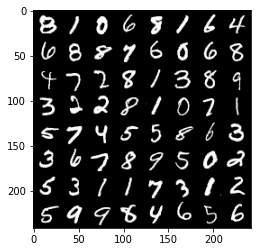

In [ ]:
%pylab inline
import numpy as np

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Как выглядит классификация с RNN в общем виде 

<img src="https://cdn-images-1.medium.com/max/1600/1*vhAfRLlaeOXZ-bruv7Ostg.png" width="400">

In [ ]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super().__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [ ]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[ 1.8370e-02,  2.3154e-02, -1.2838e-01, -4.0509e-02,  8.2185e-03,
          4.2148e-03, -3.9843e-02, -2.7017e-02, -6.1318e-03, -8.5649e-02],
        [ 1.6254e-02,  3.2658e-02, -1.6285e-01, -6.3373e-02, -2.5382e-02,
         -3.8727e-03, -3.1898e-02, -4.0651e-02,  2.5157e-02, -6.5200e-02],
        [ 1.5563e-02,  6.8045e-03, -1.2239e-01, -4.9506e-02,  1.8576e-02,
          8.6509e-05, -3.5483e-02, -2.0090e-02, -5.1611e-03, -8.4599e-02],
        [ 2.0693e-02,  1.3575e-02, -1.3905e-01, -2.7416e-02, -5.2042e-03,
          2.0611e-02, -4.8334e-02, -5.9789e-02, -9.0291e-03, -6.2105e-02],
        [ 1.9504e-02,  1.7026e-02, -1.3455e-01, -3.9351e-02, -5.6947e-03,
         -5.4658e-03, -4.9576e-02, -2.4008e-02,  1.9284e-02, -7.3955e-02],
        [ 1.7493e-02,  5.6381e-03, -1.3451e-01, -3.9035e-02,  1.6057e-02,
         -2.0677e-03, -3.3517e-02, -2.5358e-02,  2.9711e-03, -7.5611e-02],
        [ 1.2407e-02,  4.5758e-03, -1.4874e-01, -4.4669e-02,  3.1274e-03,
          1.7384e-03, -4.9302e-0

## Обучаем

In [ ]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.8455 | Train Accuracy: 70.93
Epoch:  1 | Loss: 0.4047 | Train Accuracy: 87.17
Epoch:  2 | Loss: 0.2563 | Train Accuracy: 92.62
Epoch:  3 | Loss: 0.2014 | Train Accuracy: 94.28


KeyboardInterrupt: ignored

### Смотрим что на тесте

In [ ]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

# Сентимент анализ

Домашка — классифицировать отзывы с IMDB на положительный / отрицательный только по тексту.

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment1.png">

Суть такая же, только нужно предобработать тексты — каждому слову сопоставить обучаемый вектор (embedding), который пойдёт дальше в RNN.

In [ ]:
# это уберет боль работы с текстами
# pip uninstall torchtext
!pip install torchtext==0.4.0
!pip install torchdata
# !pip install torchtext
# !python -m spacy download en

     |████████████████████████████████| 53 kB 1.3 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
     |████████████████████████████████| 47 kB 2.5 MB/s 
     |████████████████████████████████| 138 kB 9.8 MB/s 
     |████████████████████████████████| 127 kB 44.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# !pip install https://github.com/pytorch/text/archive/master.zip
# from torchtext import data

**Примечание.** Torchtext уже не очень живой проект, а в spacy нет русского.


In [ ]:
# import torch
# # from torchtext import data
from torchtext import data
# from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)


In [ ]:
from torchtext import datasets


train_data, test_data = datasets.IMDB.splits(TEXT, LABEL, root="./data")
# train_data, test_data = datasets.IMDB(split='train')

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 24.6MB/s]


In [ ]:
ls -lh data/imdb/aclImdb/

total 1.7M
-rw-r--r-- 1 7297 1000 882K Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 7297 1000 827K Apr 12  2011 imdb.vocab
-rw-r--r-- 1 7297 1000 4.0K Jun 26  2011 README
drwxr-xr-x 4 7297 1000 4.0K Apr 12  2011 test/
drwxr-xr-x 5 7297 1000 4.0K Jun 26  2011 train/


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [ ]:
print(vars(train_data.examples[0]))

{'text': ['There', 'is', 'one', 'detail', ',', 'which', 'is', 'not', 'very', 'common', 'for', 'Jackie', 'Chan', 'movies', ',', 'but', 'which', 'is', 'present', 'here', '.', 'It', 'has', 'some', 'very', 'tough', 'and', 'serious', 'atmosphere', 'about', 'it', 'while', 'the', 'funny', 'elements', 'are', 'present', 'too', '.', 'Jackie', 'is', 'menacing', 'and', 'psychotic', 'here', '.', 'He', 'is', 'not', 'a', 'hero', 'who', 'is', 'attacked', 'and', 'only', 'then', 'fights', 'back', '(', 'in', 'a', 'usual', 'laid', '-', 'back', 'pattern', ')', ',', 'but', 'he', 'is', 'the', 'one', 'who', 'can', 'go', 'and', 'start', 'the', 'tumult', '.', 'His', 'manner', 'of', 'hitting', 'that', 'evil', 'guy', 'in', 'the', 'glasses', 'is', 'amazing', '.', 'Every', 'time', 'it', 'goes', '"', 'crack', '!', '"', '.', 'I', 'also', 'especially', 'enjoy', 'the', 'scene', 'when', 'Jackie', 'goes', 'to', 'the', 'pub', 'and', 'thrashes', 'the', 'villains', 'who', 'had', 'fronted', 'on', 'his', 'girlfriend', '.', 'I

In [ ]:
# Сделаем еще eval
import random

train_data, valid_data = train_data.split(random_state=random.seed(SEED))

In [ ]:
# Сделаем словарь
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [ ]:
vars(LABEL.vocab)

{'freqs': Counter({'neg': 8810, 'pos': 8690}),
 'itos': ['neg', 'pos'],
 'stoi': defaultdict(None, {'neg': 0, 'pos': 1}),
 'unk_index': None,
 'vectors': None}

Почему 25002, а не 25000?
Потому что $<unk>$ и $<pad>$

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment6.png" width="160">

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 202498), (',', 191881), ('.', 165728), ('a', 109179), ('and', 109101), ('of', 100715), ('to', 93773), ('is', 75761), ('in', 61345), ('I', 54611), ('it', 53705), ('that', 49163), ('"', 44220), ("'s", 42995), ('this', 42304), ('-', 36639), ('was', 35391), ('/><br', 35233), ('as', 30222), ('with', 30015)]


* stoi (string to int)
* itos (int to string)

In [ ]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'a', 'and', 'of', 'to', 'is']


In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


In [ ]:
l = []
for i in train_data.label:
    l.append(i)
    
np_ar = np.array(l)
unique, counts = np.unique(l, return_counts=True)
dict(zip(unique, counts))

{'neg': 8810, 'pos': 8690}

{'neg': 8810, 'pos': 8690}

In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# собираем батчи так, чтобы в каждом батче были примеры наиболее похожей длины
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device)

## Делаем модель

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment7.png" width="450">

* В эмбеддер (emb = [torch.nn.Embedding(num_embeddings, embedding_dim)](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding)) запихиваем тензор размерностью **[sentence length, batch size]**
* Эмбеддер возвращает тензор размерностью **[sentence length, batch size, embedding dim]**
* RNN (torch.nn.RNN(embedding_dim, hidden_dim)) возвращает 2 тензора, *output* размера [sentence length, batch size, hidden dim] и *hidden* размера [1, batch size, hidden dim]

In [ ]:
# class RNN(nn.Module):
#     def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
#         super().__init__()
        
#         self.embedding = nn.Embedding(input_dim, embedding_dim)
#         self.rnn = nn.RNN(embedding_dim, hidden_dim)
#         self.fc = nn.Linear(hidden_dim, output_dim)
#         #self.fc = ? # можно добавить линейный слой, который делает проекцию в 2 класса
    

#         #text, shape = [sent len, batch size]
#     def forward(self, text):
#         embedded = self.embedding(text)
#         output, hidden = self.rnn(embedded)

#         assert torch.equal(output[-1, :, :], hidden.squeeze(0))
#         return self.fc(hidden.squeeze(0))


# 1111111111111111

In [ ]:
import torch
from torchtext import data

SEED = 1370

torch.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)
# LABEL = data.LabelField(dtype=float)
# TypeError: tensor(): argument 'dtype' must be torch.dtype, not type

from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

import random

train_data, valid_data = train_data.split(random_state=random.seed(SEED))

MAX_VOCAB = 25000
TEXT.build_vocab(train_data, max_size=MAX_VOCAB)
LABEL.build_vocab(train_data)

BATCH_SIZE = 128


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data),
                                                                           batch_size=BATCH_SIZE, device=device)
# valid_iterator valid_data
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        assert torch.equal(output[-1, :, :], hidden.squeeze(0))
        return self.fc(hidden.squeeze(0))


INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 500
HIDDEN_DIM = 512
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-2)
criterion = nn.BCEWithLogitsLoss()

# https://stackoverflow.com/questions/50954479/using-cuda-with-pytorch

model = model.to(device)
criterion = criterion.to(device)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 21.7MB/s]


In [ ]:
def binary_accurancy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    # print('\n', correct)
    acc = (correct).sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    n_iter_all = 0
    
    for batch in iterator:
        n_iter_all += 1
    print(n_iter_all)
    n_iter = 0
    
    for batch in iterator:
        if n_iter % 10 == 0:
            print(n_iter / n_iter_all)

        optimizer.zero_grad()
        # print(1)
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        # print('\n predictions', predictions, '\n\n batch', batch.label)
        acc = binary_accurancy(predictions, batch.label)

        loss.backward()
        optimizer.step()

        epoch_acc += acc.item()
        epoch_loss += loss.item()

        n_iter += 1
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    epoch_acc = 0
    epoch_loss = 0

    model.eval()

    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text).squeeze(1)

            loss = criterion(predictions, batch.label)

            acc = binary_accurancy(predictions, batch.label)

            epoch_acc += acc.item()
            epoch_loss += loss.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


EPOCHS_NUM = 10

# ???
best_valid_loss = float('inf')

import time


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


for epoch in range(EPOCHS_NUM):
    print(str(epoch/EPOCHS_NUM * 100), '%')
    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print('Epoch', epoch + 1, '| Epoch Time : ', epoch_mins, 'm', epoch_secs, 's')
    print('\t Train Loss： |', train_loss, '  Train  Acc :', train_acc * 100, '%')
    print('\t valid Loss： |', valid_loss, '  valid  Acc :', valid_acc * 100, '%')

0.0 %
137
0.0
0.072992700729927
0.145985401459854
0.21897810218978103
0.291970802919708
0.36496350364963503
0.43795620437956206
0.5109489051094891
0.583941605839416
0.656934306569343
0.7299270072992701
0.8029197080291971
0.8759124087591241
0.948905109489051
Epoch 1 | Epoch Time :  74 m 26 s
	 Train Loss： | 0.6955292725214993   Train  Acc : 49.6863594890511 %
	 valid Loss： | 0.6946924076241962   valid  Acc : 50.564507155095114 %
10.0 %
137
0.0
0.072992700729927
0.145985401459854
0.21897810218978103
0.291970802919708
0.36496350364963503
0.43795620437956206
0.5109489051094891
0.583941605839416
0.656934306569343
0.7299270072992701
0.8029197080291971
0.8759124087591241
0.948905109489051
Epoch 2 | Epoch Time :  74 m 58 s
	 Train Loss： | 0.6955281835402886   Train  Acc : 49.5790026918815 %
	 valid Loss： | 0.6947432695809057   valid  Acc : 50.43766730922764 %
20.0 %
137
0.0
0.072992700729927
0.145985401459854
0.21897810218978103
0.291970802919708
0.36496350364963503
0.43795620437956206
0.51094

KeyboardInterrupt: ignored